# NDVI数据处理
初始数据是格式(t: 25, x: 76, y: 49) 的nc文件，目标是(time: 37, y: 76, x: 49)的ndvi_precombine.nc。


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

nc_path = "./ndvi_Grandvillers_au_bois.nc"

In [2]:
# load dataset
ds = xr.open_dataset(nc_path)


print("✅ Dataset 读取成功")
print(ds)

# Inspect dataset structure
print("\n--- dims ---")
print(ds.dims)

print("\n--- coords ---")
print(list(ds.coords))

print("\n--- data variables ---")
print(list(ds.data_vars))

✅ Dataset 读取成功
<xarray.Dataset> Size: 374kB
Dimensions:  (t: 25, x: 76, y: 49)
Coordinates:
  * t        (t) datetime64[ns] 200B 2025-04-02 2025-04-06 ... 2025-08-25
  * x        (x) float64 608B 4.72e+05 4.72e+05 4.72e+05 ... 4.727e+05 4.727e+05
  * y        (y) float64 392B 5.48e+06 5.48e+06 5.48e+06 ... 5.48e+06 5.48e+06
Data variables:
    crs      |S1 1B ...
    var      (t, y, x) float32 372kB ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

--- dims ---
FrozenMappingWarningOnValuesAccess({'t': 25, 'x': 76, 'y': 49})

--- coords ---
['t', 'x', 'y']

--- data variables ---
['crs', 'var']


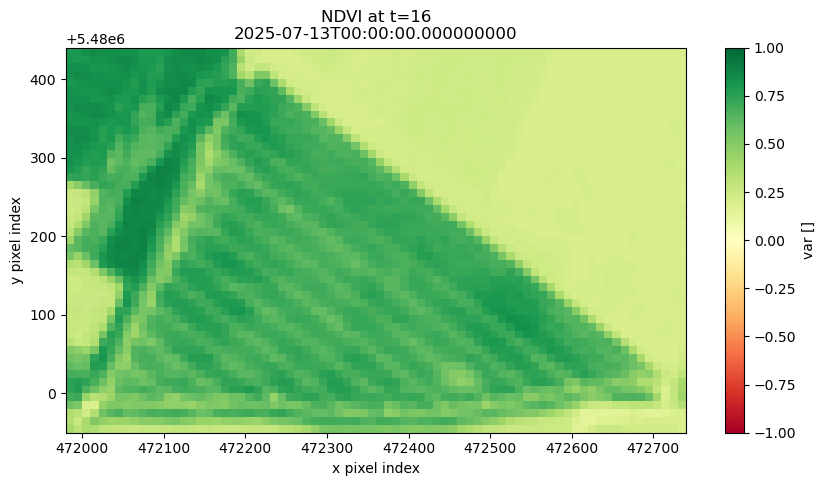

In [3]:
# Plot NDVI at specific time index
da = ds["var"]

t_idx = 16  # 改成 0 / 1 / 2
da.isel(t=t_idx).plot(
    figsize=(10, 5),
    vmin=-1,
    vmax=1,
    cmap="RdYlGn",
    add_colorbar=True
)
plt.xlabel("x pixel index")
plt.ylabel("y pixel index")
plt.title(f"NDVI at t={t_idx}\n{str(ds['t'].values[t_idx])}")
plt.show()

In [4]:
# Print time coordinate values
ds["t"].values


array(['2025-04-02T00:00:00.000000000', '2025-04-06T00:00:00.000000000',
       '2025-04-07T00:00:00.000000000', '2025-04-09T00:00:00.000000000',
       '2025-04-27T00:00:00.000000000', '2025-04-29T00:00:00.000000000',
       '2025-05-02T00:00:00.000000000', '2025-05-14T00:00:00.000000000',
       '2025-05-16T00:00:00.000000000', '2025-05-22T00:00:00.000000000',
       '2025-06-13T00:00:00.000000000', '2025-06-18T00:00:00.000000000',
       '2025-06-21T00:00:00.000000000', '2025-07-01T00:00:00.000000000',
       '2025-07-03T00:00:00.000000000', '2025-07-11T00:00:00.000000000',
       '2025-07-13T00:00:00.000000000', '2025-07-18T00:00:00.000000000',
       '2025-08-07T00:00:00.000000000', '2025-08-10T00:00:00.000000000',
       '2025-08-12T00:00:00.000000000', '2025-08-15T00:00:00.000000000',
       '2025-08-17T00:00:00.000000000', '2025-08-24T00:00:00.000000000',
       '2025-08-25T00:00:00.000000000'], dtype='datetime64[ns]')

经过检查，初始ndvi数据时间不规则，且有两个文件有问题不能用，所以先删掉两个坏文件

Upon inspection, the initial ndvi data had irregular timings, and two files were found to be faulty and unusable. Therefore, the two faulty files were deleted.

In [5]:
import pandas as pd

# 1) 明确坏掉的日期
bad_dates = pd.to_datetime([
    "2025-07-18",
    "2025-08-07",
])

# 2) 在插值前，直接从时间维度删掉
da_clean = ds["var"].drop_sel(t=bad_dates)

print("原始 t 长度:", ds.dims["t"])
print("清洗后 t 长度:", da_clean.sizes["t"])
print("剩余时间点：")
print(da_clean["t"].values)


原始 t 长度: 25
清洗后 t 长度: 23
剩余时间点：
['2025-04-02T00:00:00.000000000' '2025-04-06T00:00:00.000000000'
 '2025-04-07T00:00:00.000000000' '2025-04-09T00:00:00.000000000'
 '2025-04-27T00:00:00.000000000' '2025-04-29T00:00:00.000000000'
 '2025-05-02T00:00:00.000000000' '2025-05-14T00:00:00.000000000'
 '2025-05-16T00:00:00.000000000' '2025-05-22T00:00:00.000000000'
 '2025-06-13T00:00:00.000000000' '2025-06-18T00:00:00.000000000'
 '2025-06-21T00:00:00.000000000' '2025-07-01T00:00:00.000000000'
 '2025-07-03T00:00:00.000000000' '2025-07-11T00:00:00.000000000'
 '2025-07-13T00:00:00.000000000' '2025-08-10T00:00:00.000000000'
 '2025-08-12T00:00:00.000000000' '2025-08-15T00:00:00.000000000'
 '2025-08-17T00:00:00.000000000' '2025-08-24T00:00:00.000000000'
 '2025-08-25T00:00:00.000000000']


C:\Users\WIN7\AppData\Local\Temp\ipykernel_28884\419505814.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("原始 t 长度:", ds.dims["t"])


## 线性插值
初始数据太少，所以做了每三天一个ndvi的线性插值。通常来说，ndvi的变化往往是近似线性的，也没有出现极端天气，所以这种情况下的线性插值用于训练是完全可以的。
## Linear Interpolation 
Since the initial data was too limited, linear interpolation was performed every three days for the ndvi. Generally, ndvi changes are approximately linear, and there were no extreme weather events, so linear interpolation under these circumstances is perfectly acceptable for training.

In [6]:
# 你的 NDVI
da = da_clean   # dims: (t, y, x)

# 1) 生成严格每3天的时间轴
t0 = pd.to_datetime("2025-05-07")
t1 = pd.to_datetime(da["t"].values.max())
target_t = pd.date_range(start=t0, end=t1, freq="3D")

# 2) 线性插值到每3天  关键步骤
da_3d = da.interp(t=target_t, method="linear")

# 3) 可选：限制到 NDVI 合理范围（保险）
da_3d = da_3d.clip(-1, 1)

# 4) 存回 Dataset（方便后续和天气数据对齐）
ds_3d = da_3d.to_dataset(name="ndvi_3d")

print(ds_3d)
print("new t length =", ds_3d.dims["t"])
print("t head:", ds_3d["t"].values[:5])
print("t tail:", ds_3d["t"].values[-5:])


<xarray.Dataset> Size: 1MB
Dimensions:  (x: 76, y: 49, t: 37)
Coordinates:
  * x        (x) float64 608B 4.72e+05 4.72e+05 4.72e+05 ... 4.727e+05 4.727e+05
  * y        (y) float64 392B 5.48e+06 5.48e+06 5.48e+06 ... 5.48e+06 5.48e+06
  * t        (t) datetime64[ns] 296B 2025-05-07 2025-05-10 ... 2025-08-23
Data variables:
    ndvi_3d  (t, y, x) float64 1MB 0.2091 0.202 0.2014 ... 0.13 0.1784 0.2167
new t length = 37
t head: ['2025-05-07T00:00:00.000000000' '2025-05-10T00:00:00.000000000'
 '2025-05-13T00:00:00.000000000' '2025-05-16T00:00:00.000000000'
 '2025-05-19T00:00:00.000000000']
t tail: ['2025-08-11T00:00:00.000000000' '2025-08-14T00:00:00.000000000'
 '2025-08-17T00:00:00.000000000' '2025-08-20T00:00:00.000000000'
 '2025-08-23T00:00:00.000000000']


C:\Users\WIN7\AppData\Local\Temp\ipykernel_28884\3191949594.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("new t length =", ds_3d.dims["t"])


In [7]:
ds_3d["t"].values   # new time coordinates after interpolation

array(['2025-05-07T00:00:00.000000000', '2025-05-10T00:00:00.000000000',
       '2025-05-13T00:00:00.000000000', '2025-05-16T00:00:00.000000000',
       '2025-05-19T00:00:00.000000000', '2025-05-22T00:00:00.000000000',
       '2025-05-25T00:00:00.000000000', '2025-05-28T00:00:00.000000000',
       '2025-05-31T00:00:00.000000000', '2025-06-03T00:00:00.000000000',
       '2025-06-06T00:00:00.000000000', '2025-06-09T00:00:00.000000000',
       '2025-06-12T00:00:00.000000000', '2025-06-15T00:00:00.000000000',
       '2025-06-18T00:00:00.000000000', '2025-06-21T00:00:00.000000000',
       '2025-06-24T00:00:00.000000000', '2025-06-27T00:00:00.000000000',
       '2025-06-30T00:00:00.000000000', '2025-07-03T00:00:00.000000000',
       '2025-07-06T00:00:00.000000000', '2025-07-09T00:00:00.000000000',
       '2025-07-12T00:00:00.000000000', '2025-07-15T00:00:00.000000000',
       '2025-07-18T00:00:00.000000000', '2025-07-21T00:00:00.000000000',
       '2025-07-24T00:00:00.000000000', '2025-07-27

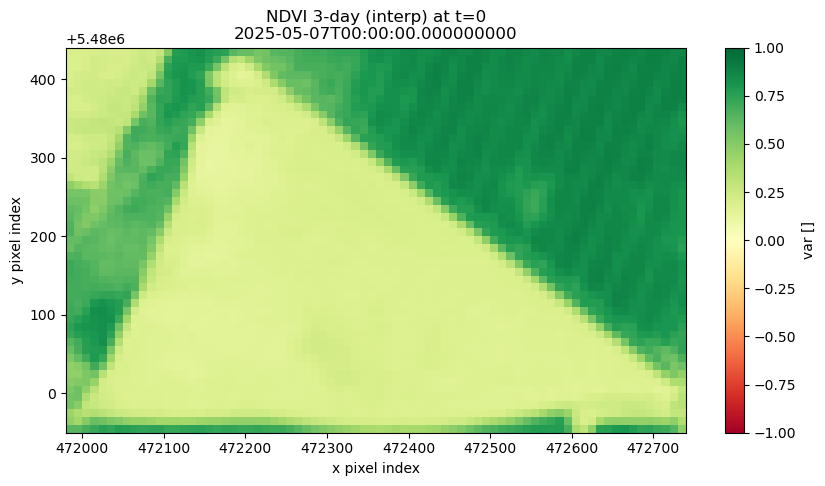

In [ ]:
# Plot interpolated NDVI at specific time index
t_idx = 0  # 这里填t的index
ds_3d["ndvi_3d"].isel(t=t_idx).plot(
    figsize=(10, 5),
    vmin=-1, vmax=1,
    cmap="RdYlGn",
    add_colorbar=True
)
plt.xlabel("x pixel index")
plt.ylabel("y pixel index")
plt.title(f"NDVI 3-day (interp) at t={t_idx}\n{str(ds_3d['t'].values[t_idx])}")
plt.show()

In [ ]:
# make final NDVI DataArray with correct naming and dimension order
ndvi_pre = da_3d.rename({"t": "time"}).rename("ndvi")

ndvi_pre = ndvi_pre.transpose("time", "y", "x")

ndvi_ds_pre = ndvi_pre.to_dataset()
ndvi_ds_pre


<xarray.Dataset> Size: 1MB
Dimensions:  (x: 76, y: 49, time: 37)
Coordinates:
  * x        (x) float64 608B 4.72e+05 4.72e+05 4.72e+05 ... 4.727e+05 4.727e+05
  * y        (y) float64 392B 5.48e+06 5.48e+06 5.48e+06 ... 5.48e+06 5.48e+06
  * time     (time) datetime64[ns] 296B 2025-05-07 2025-05-10 ... 2025-08-23
Data variables:
    ndvi     (time, y, x) float64 1MB 0.2091 0.202 0.2014 ... 0.13 0.1784 0.2167

In [ ]:
# save to netCDF for later use
out_nc = "ndvi_precombine.nc"
ndvi_ds_pre.to_netcdf(out_nc)
print("✅ Saved:", out_nc)

✅ Saved: ndvi_precombine.nc


In [ ]:
chk = xr.open_dataset("ndvi_precombine.nc")
chk

<xarray.Dataset> Size: 1MB
Dimensions:  (x: 76, y: 49, time: 37)
Coordinates:
  * x        (x) float64 608B 4.72e+05 4.72e+05 4.72e+05 ... 4.727e+05 4.727e+05
  * y        (y) float64 392B 5.48e+06 5.48e+06 5.48e+06 ... 5.48e+06 5.48e+06
  * time     (time) datetime64[ns] 296B 2025-05-07 2025-05-10 ... 2025-08-23
Data variables:
    ndvi     (time, y, x) float64 1MB ...

C:\Users\WIN7\AppData\Local\Temp\ipykernel_8408\1665326840.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


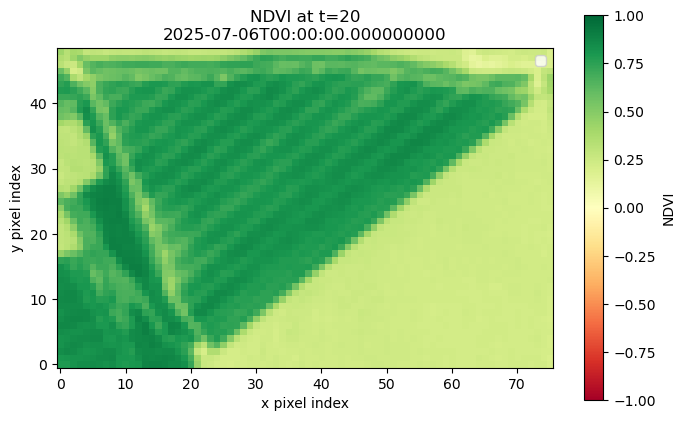

In [5]:
import matplotlib.pyplot as plt

t_idx = 20
img = chk["ndvi"].isel(time=t_idx).values  # (y, x)

plt.figure(figsize=(8, 5))
plt.imshow(
    img,
    origin="lower",   # 非常重要：保证 y 方向和像素索引一致
    vmin=-1,
    vmax=1,
    cmap="RdYlGn"
)

plt.colorbar(label="NDVI")
plt.xlabel("x pixel index")
plt.ylabel("y pixel index")
plt.title(f"NDVI at t={t_idx}\n{chk['time'].values[t_idx]}")
plt.legend()
plt.show()



C:\Users\WIN7\AppData\Local\Temp\ipykernel_8408\239421044.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


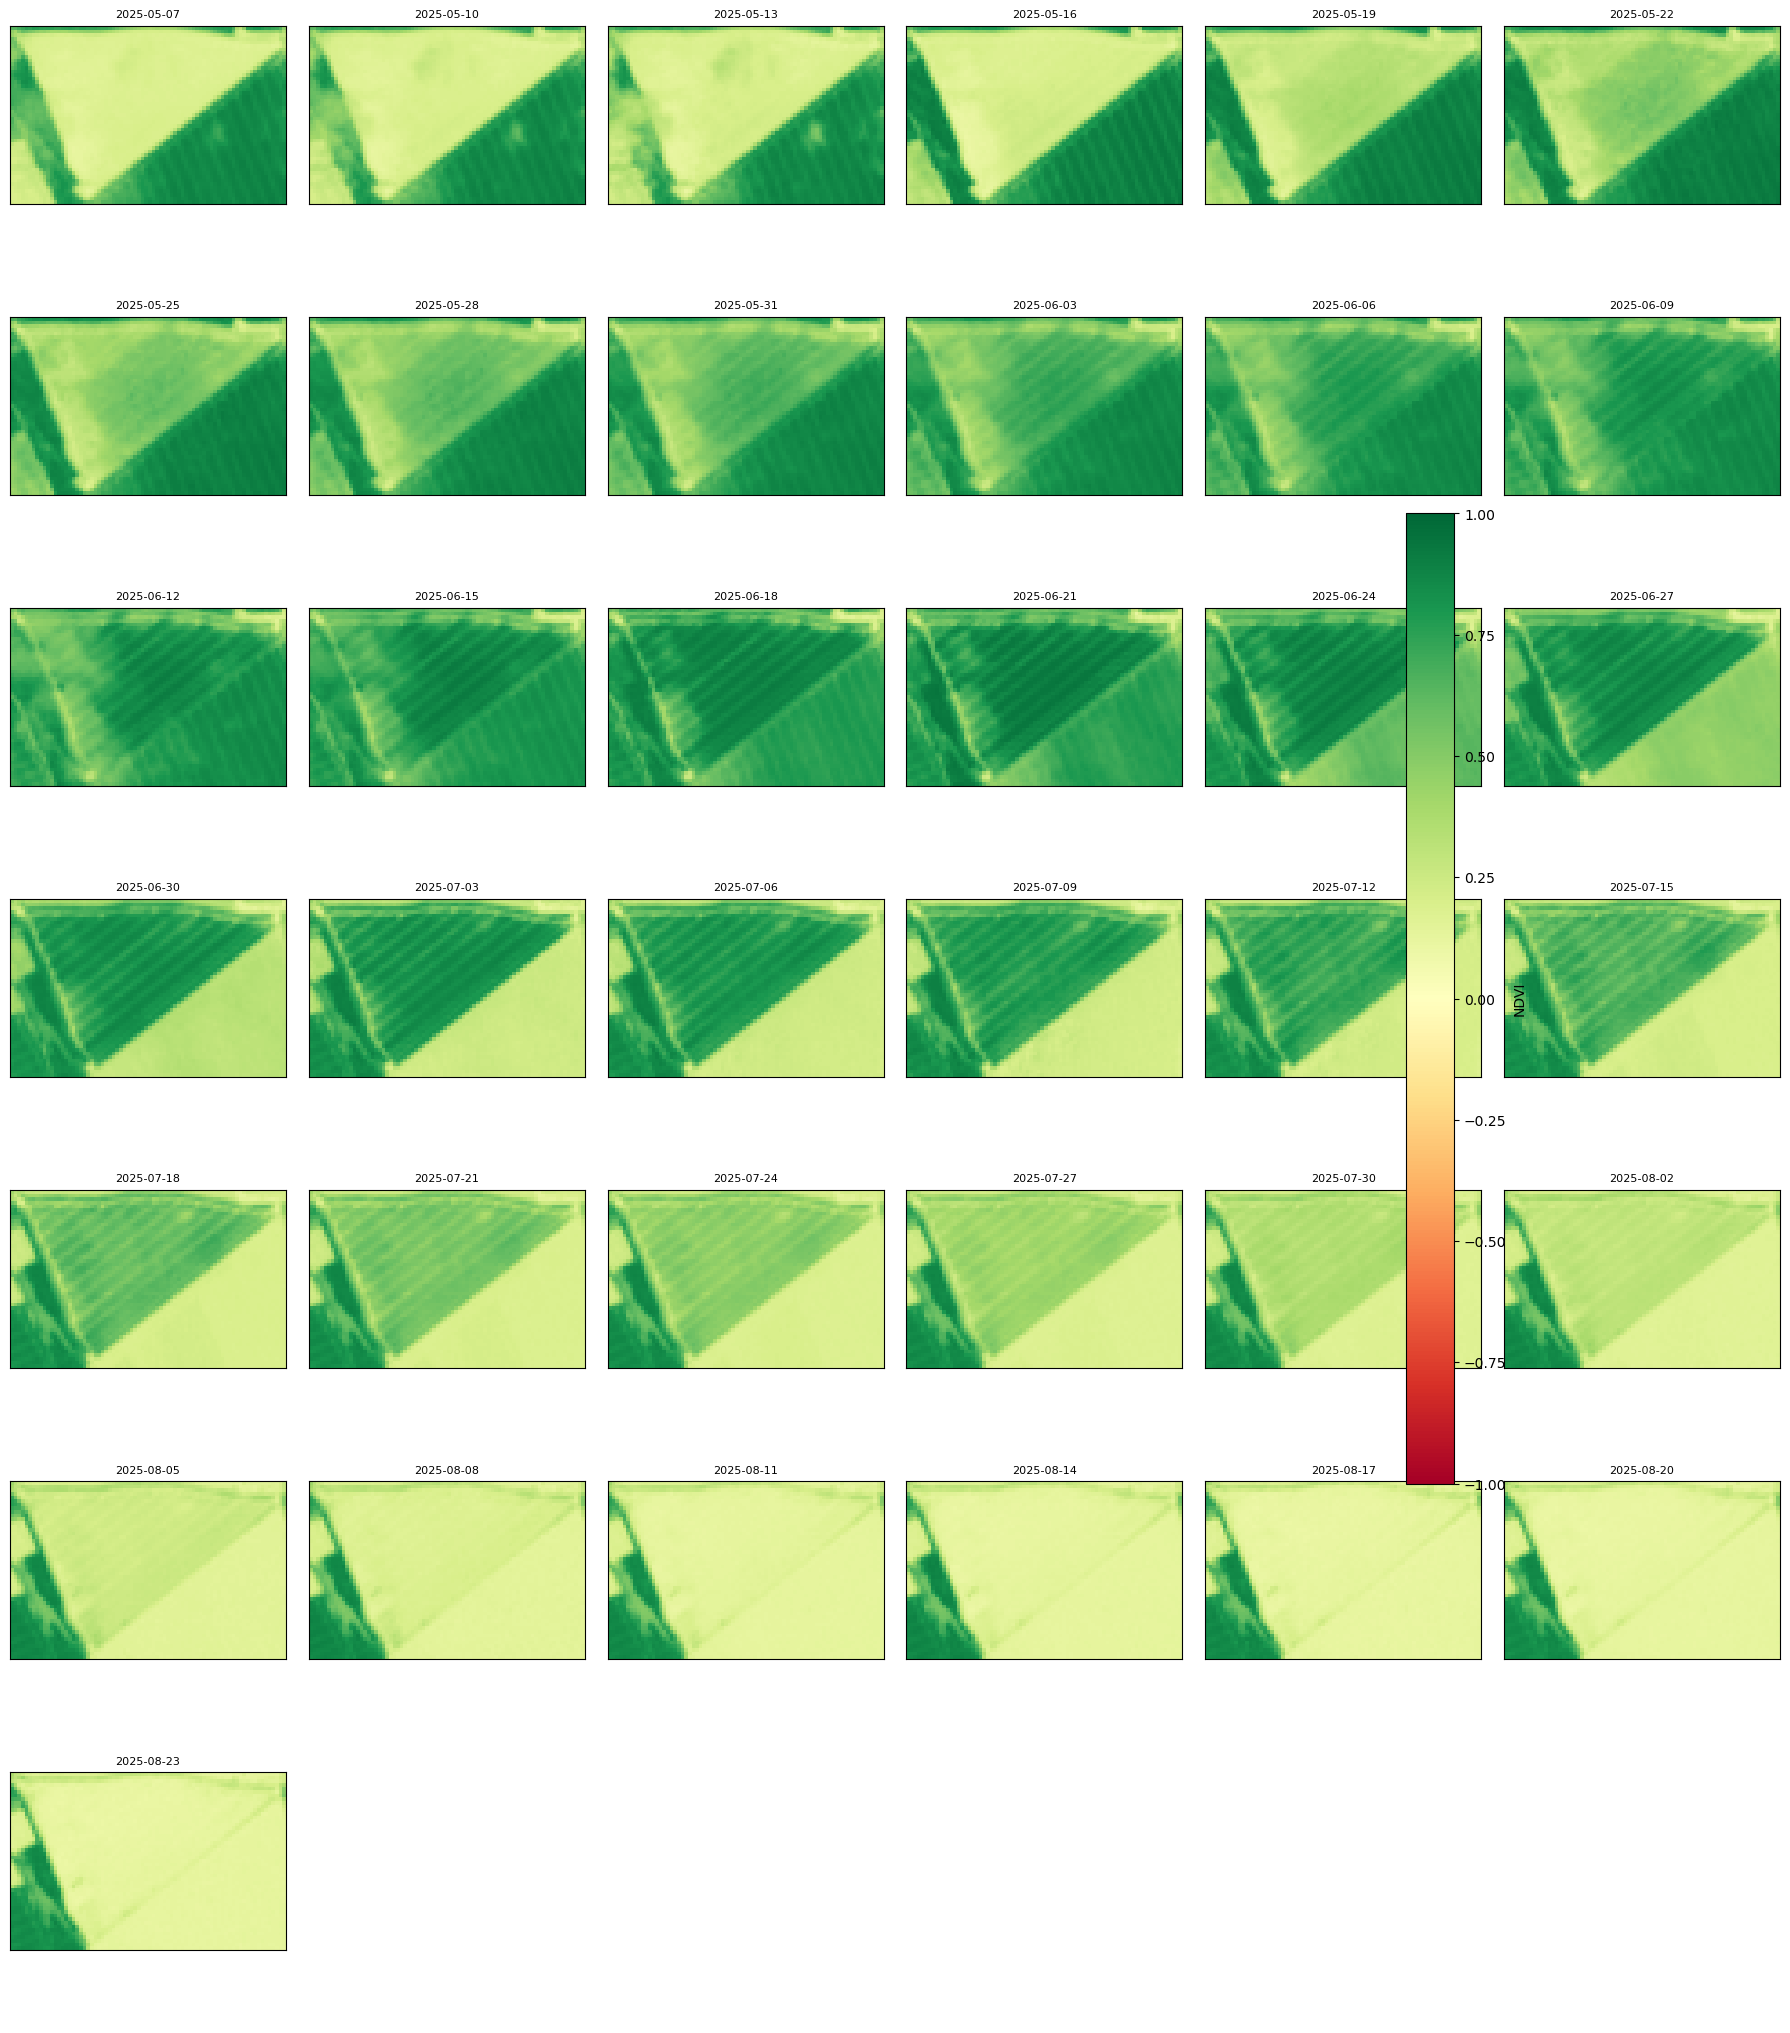

In [8]:
import matplotlib.pyplot as plt
import math

ndvi = chk["ndvi"]
T = ndvi.sizes["time"]

ncols = 6                       # 每行 6 张
nrows = math.ceil(T / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(3 * ncols, 3 * nrows),
    squeeze=False
)

for i in range(T):
    r = i // ncols
    c = i % ncols
    ax = axes[r, c]

    img = ndvi.isel(time=i).values
    im = ax.imshow(
        img,
        origin="lower",
        vmin=-1,
        vmax=1,
        cmap="RdYlGn"
    )
    ax.set_title(str(ndvi["time"].values[i])[:10], fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# 多余的子图关掉
for j in range(T, nrows * ncols):
    axes[j // ncols, j % ncols].axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="NDVI")
plt.tight_layout()
plt.show()


